In [97]:
import csv
import glob
import pickle
import numpy as np
import pandas as pd
import networkx as nx
import dask.dataframe as dd
import multiprocessing as mp
import xml.etree.ElementTree as ET

* <s> How large a group of co-authors does the average publication have? </s>
* Do authors mostly publish using always the same group of authors?
* Do authors mainly reference papers with other authors with whom they've co-authored papers (including themselves)?
* What is the distribution in time for citations of papers in general, and for papers with the highest number of citations? Do they differ?
* Is there a correlation between citations and the number of keywords that papers share? I.e. papers which share the same subject cite each other more often.
* For the most-cited papers (define your own cutoff), is the correlation in shared keywords between them and the papers that cite them different from (5) 

# Reading and combining pickles.

In [12]:
pickle_path = '/students/2021-2022/master/Rients_DSLS/pickle_6/'
pickles = glob.glob(pickle_path + 'pubmed21n*.pkl')

In [13]:
# Creating a bipartite graph of papers and authors.
# ~14min
full_graph = nx.Graph()
nr = 0
for pickle in pickles:
    # Creating a pandas dataframe from each pickle
    df = pd.read_pickle(pickle)
    nr += 1 
    # Creating 1 graph from the dataframe.
    for l, p in zip(df[0],df[1]):
        full_graph.add_edge(l,p)
        full_graph.add_edge(p,l)
    print('Added nodes to graph', nr)
# Creating a 4.3 gb graph.
#nx.write_gpickle(full_graph, path='/students/2021-2022/master/Rients_DSLS/pickle_graph/full_graph.pkl')
#~ 14 min

Added nodes to graph 1


In [3]:
# Creating a dataframe that has all the authors and their corresponding paper.
ddf2 = dd
ddf_list = []

for pickle in pickles:
    # Creating a pandas dataframe from each pickle
    df = pd.read_pickle(pickle)

    # Turning pandas df into a dask dataframe.
    ddf = dd.from_pandas(df, npartitions=8)
    ddf_list.append(ddf)   
    nr = len(ddf_list)
    print('list size: ', nr, '/1062')

print('Combining dataframes. ETA: ~20 sec')
full_frame = dd.multi.concat(ddf_list)
# ~2 min

list size:  1 /1062
list size:  2 /1062
list size:  3 /1062
list size:  4 /1062
list size:  5 /1062
list size:  6 /1062
list size:  7 /1062
list size:  8 /1062
list size:  9 /1062
list size:  10 /1062
list size:  11 /1062
list size:  12 /1062
list size:  13 /1062
list size:  14 /1062
list size:  15 /1062
list size:  16 /1062
list size:  17 /1062
list size:  18 /1062
list size:  19 /1062
list size:  20 /1062
list size:  21 /1062
list size:  22 /1062
list size:  23 /1062
list size:  24 /1062
list size:  25 /1062
list size:  26 /1062
list size:  27 /1062
list size:  28 /1062
list size:  29 /1062
list size:  30 /1062
list size:  31 /1062
list size:  32 /1062
list size:  33 /1062
list size:  34 /1062
list size:  35 /1062
list size:  36 /1062
list size:  37 /1062
list size:  38 /1062
list size:  39 /1062
list size:  40 /1062
list size:  41 /1062
list size:  42 /1062
list size:  43 /1062
list size:  44 /1062
list size:  45 /1062
list size:  46 /1062
list size:  47 /1062
list size:  48 /1062
l

## Question 1
How large a group of co-authors does the average publication have?

How to answer: <br>
Check the total amount of authors divided by the amount of unique pubmedIDs.

In [ ]:
# Question1.
Full_df = full_frame
total = len(Full_df) 
uniques = Full_df[0].nunique().compute()
average_authors = total / uniques

In [8]:
# Writing the answers.
with open('answers.csv', mode='w') as csv_file:
    answer_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    answer_writer.writerow(['How large a group of co-authors does the average publication have?', round(average_authors,2)])
    print('The papers have', average_authors, 'authors on average')

The papers have 4.1985290298819535 authors on average


## Graph observations

In [2]:
loaded_graph = nx.read_gpickle('/students/2021-2022/master/Rients_DSLS/pickle_graph/full_graph.pkl')
# ~ 7 minutes.

In [75]:
# In total there are 48996125 nodes.
total_nodes = len(loaded_graph)

In [28]:
# Loading all the subgraphs.
loaded_components = sorted(nx.connected_components(loaded_graph), key=len, reverse=True)
# In total 727593 different subgraphs exist. 
total_cc = len(loaded_components)
total_cc
# ~ 3m 25 min

In [85]:
# The first subgraph has 46720986 nodes
loaded_sg0 = loaded_graph.subgraph(loaded_components[0])
length_sg0 = len(loaded_sg0)
length_sg0

46720986

In [84]:
# The second already drops down to 1101
# In this graph all articles are written by 'springer medizin' a german publication company. No co-authors and no connections.
loaded_sg1 = loaded_graph.subgraph(loaded_components[1])
length_sg1 = len(loaded_sg1)
length_sg1

1101

In [87]:
# 95% of all the nodes are in the first connected subgraph.
(length_sg0 / total_nodes)*100

95.35649196747701

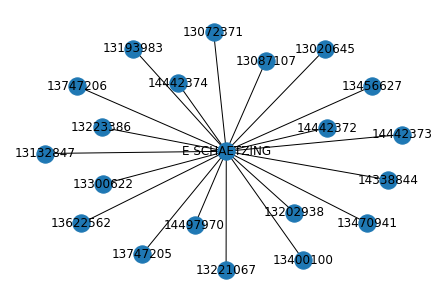

In [62]:
# a lot of the non main connected graphs look like this.
loaded_sg3000 = loaded_graph.subgraph(loaded_components[3000])
nx.draw(loaded_sg3000, with_labels=True)
# a author that never uses a co author with multiple old papers  

I could try and incorperate all the subgraphs into my answers. <br>
But doing this will require a lot more work for I believe not a lot more answers. 

A lot of these graphs are old authors that have written a lot of papers with no co-author. <Br>
And also a lot of  'company authors' like 'Food and Drug Administration' and 'springer medizin' hiding the actual authors.
### INSERT EXPLANATION

Therefore I will just take the first subgraph representing the 95% of data as main graph

In [90]:
# This shows the nodes with the most connections. 
# Aka the authors with the most papers. (or the papers with the most authors but that won't show up in the top)
# It shows some authors with 15k + papers.
# Altough with very common names so it is probably more than 1 author but with the given xml file there is no way to check this.
sorted(loaded_sg0.degree, key=lambda x: x[1], reverse=True)[:10]
# ~ 6.5 min

[('Wei Wang', 15254),
 ('Wei Zhang', 13897),
 ('Wei Li', 11040),
 ('Jing Wang', 10499),
 ('Yan Li', 10418),
 ('Yan Wang', 9503),
 ('Jing Li', 9494),
 ('Lei Zhang', 9405),
 ('Yang Liu', 9296),
 ('Yan Zhang', 9282)]

In [91]:
#Computing centrality
degCent = nx.degree_centrality(loaded_sg0)
#Descending order sorting centrality
degCent_sorted=dict(sorted(degCent.items(), key=lambda item: item[1],reverse=True))
# ~ 7 mins

## Question 2
Do authors mostly publish using always the same group of authors?

How to answer, notes: <br>

Check if neighbouring nodes often share the same neighbours? <br>
Check for communities. <br>
Network transitivity <br>
Check for modularity - difficult in bipartite graphs. <br>
Guimeras modularity  https://www.researchgate.net/publication/5915523_Module_identification_in_bipartite_and_directed_networks <br>
Check for modular structure
<br>
Plotting the bipartite map and apply clustering to check for communities 
Will require some speciliased program. 

<br>
Instead of a bipartite graph. 
Make a citation graph with only papers. Adding authors as attributes.
And see how often the papers share more than one author.




In [101]:
trans_sg0 = nx.transitivity(loaded_sg0)

In [ ]:
print(trans_sg0)

## Smaller Graph Checks

In [33]:
small_cc = sorted(nx.connected_components(full_graph), key=len, reverse=True)
small_sg = full_graph.subgraph(Gcc[10])

In [9]:
#Computing centrality
degCent = nx.degree_centrality(G400)
#Descending order sorting centrality
degCent_sorted=dict(sorted(degCent.items(), key=lambda item: item[1],reverse=True))

In [10]:
degCent_sorted

{'- Food and Drug Administration, HHS': 1.0,
 '24236336': 0.0020242914979757085,
 '19588572': 0.0020242914979757085,
 '15586951': 0.0020242914979757085,
 '16795943': 0.0020242914979757085,
 '25011161': 0.0020242914979757085,
 '18389921': 0.0020242914979757085,
 '21800457': 0.0020242914979757085,
 '27658316': 0.0020242914979757085,
 '26524771': 0.0020242914979757085,
 '15141676': 0.0020242914979757085,
 '28355048': 0.0020242914979757085,
 '24908684': 0.0020242914979757085,
 '27411238': 0.0020242914979757085,
 '24873019': 0.0020242914979757085,
 '20879180': 0.0020242914979757085,
 '17966560': 0.0020242914979757085,
 '17017469': 0.0020242914979757085,
 '11820252': 0.0020242914979757085,
 '20169678': 0.0020242914979757085,
 '30019868': 0.0020242914979757085,
 '21066902': 0.0020242914979757085,
 '17447341': 0.0020242914979757085,
 '21675382': 0.0020242914979757085,
 '26595943': 0.0020242914979757085,
 '25233536': 0.0020242914979757085,
 '24908687': 0.0020242914979757085,
 '20349552': 0.0020

In [16]:
# Graph from 1 xml
paper_graph = nx.from_pandas_edgelist(df, source=0, target=1)

In [58]:
Gcc = sorted(nx.connected_components(small_graph), key=len, reverse=True)
# the largest connected component is:
G0 = small_graph.subgraph(Gcc[0])

In [60]:
G40 = small_graph.subgraph(Gcc[40])

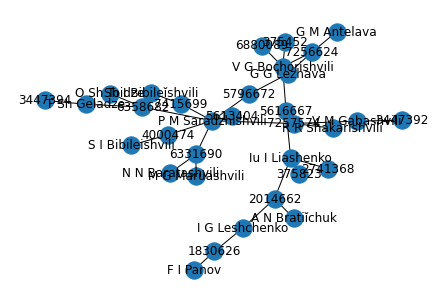

In [62]:
nx.draw(G40, with_labels = True)

In [ ]:
#Computing betweeness
betCent = nx.betweenness_centrality(G0, normalized=True, endpoints=True)

#Descending order sorting betweeness
betCent_sorted=dict(sorted(betCent.items(), key=lambda item: item[1],reverse=True))

#Computing centrality
degCent = nx.degree_centrality(G0)

#Descending order sorting centrality
degCent_sorted=dict(sorted(degCent.items(), key=lambda item: item[1],reverse=True))

In [ ]:
# Graph not connected
# eccentricity = nx.eccentricity(G0)  # The eccentricity of a node v is the maximum distance from v to all other nodes in G
# print("Eccentricity of every node:", eccentricity)

# diameter  = nx.diameter(G0) # The diameter is the maximum eccentricity 
# print("Diameter:", diameter)

# radius = nx.radius(G0) # The radius is the minimum eccentricity
# print("Radius:", radius)

degree_centrality = nx.degree_centrality(G0) # the sum of all the nodes / the sum of the neighboring nodes
print('Degree_centrality',degree_centrality)

center = nx.center(G0) # The center is the set of nodes with eccentricity equal to radius.
print("Center", center)

In [ ]:
'/students/2021-2022/master/Rients_DSLS/pickle_6/full_graph.pkl'